<a href="https://colab.research.google.com/github/alitheonly/PlantSeedling-/blob/main/0_5_Drop_SGD_All_B64_0214.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c plant-seedlings-classification
!unzip plant-seedlings-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/ad12382d4.png      
  inflating: test/adb7a032c.png      
  inflating: test/ae90f2827.png      
  inflating: test/aecfaed64.png      
  inflating: test/aee6fa3df.png      
  inflating: test/af45e222a.png      
  inflating: test/afa446484.png      
  inflating: test/afcf6abd5.png      
  inflating: test/b026bf8ca.png      
  inflating: test/b03397525.png      
  inflating: test/b0acaff4a.png      
  inflating: test/b130a0632.png      
  inflating: test/b145ba9d4.png      
  inflating: test/b1cd2a91e.png      
  inflating: test/b215531dd.png      
  inflating: test/b2706e2b3.png      
  inflating: test/b29339405.png      
  inflating: test/b30ab4659.png      
  inflating: test/b31292706.png      
  inflating: test/b341d0aab.png      
  inflating: test/b39c71707.png      
  inflating: test/b3d6fdb80.png      
  inflating: test/b3e08b037.png      
  inflating: test/b47691c08.png      
  inflating: test/b4c3df835.png      

In [ ]:

# Import necessary libraries

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
import tensorflow as tf
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import random
from glob import glob
import imageio
from keras.optimizers import SGD

In [ ]:
!ls ../content/train

 Black-grass	    'Common wheat'	'Scentless Mayweed'
 Charlock	    'Fat Hen'		'Shepherds Purse'
 Cleavers	    'Loose Silky-bent'	'Small-flowered Cranesbill'
'Common Chickweed'   Maize		'Sugar beet'


In [ ]:
data_path = '/content/'
train_dir = os.path.join(data_path,'train')
test_dir = os.path.join(data_path, 'test')

In [ ]:
images_path= '/content/train/*/*.png'
images = glob(images_path)

img_size = 224
train_images = []
train_labels = []
for i in images:
    train_images.append(cv2.resize(cv2.imread(i), (img_size, img_size))) 
    train_labels.append(i.split('/')[-2])
train_X = np.asarray(train_images)
train_Y = pd.DataFrame(train_labels)

In [ ]:
train_X

array([[[[ 71,  90, 108],
         [ 75,  93, 110],
         [ 78,  95, 114],
         ...,
         [ 59,  81,  96],
         [ 51,  73,  90],
         [ 46,  67,  90]],

        [[ 71,  90, 107],
         [ 78,  94, 112],
         [ 80,  97, 116],
         ...,
         [ 27,  48,  69],
         [ 32,  50,  71],
         [ 31,  49,  73]],

        [[ 78,  99, 115],
         [ 73,  92, 110],
         [ 75,  92, 115],
         ...,
         [ 33,  49,  70],
         [ 39,  54,  72],
         [ 39,  55,  75]],

        ...,

        [[ 60,  56,  62],
         [ 55,  51,  55],
         [ 65,  60,  64],
         ...,
         [ 41,  38,  46],
         [ 38,  37,  44],
         [ 41,  39,  48]],

        [[ 60,  56,  63],
         [ 45,  41,  43],
         [ 45,  41,  40],
         ...,
         [ 45,  42,  53],
         [ 41,  38,  47],
         [ 38,  35,  43]],

        [[ 77,  72,  82],
         [ 60,  57,  62],
         [ 58,  56,  59],
         ...,
         [ 47,  46,  53],
        

In [ ]:
train_Y

,0
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill
...,...
4745,Charlock
4746,Charlock
4747,Charlock
4748,Charlock


In [ ]:
train_Y.rename(columns={0:'species'},inplace=True)
_, train_count = np.unique(train_Y,return_counts=True)
df = pd.DataFrame(data = train_count)
a = train_Y['species'].unique()
a = a.tolist()
a.sort()
df['Index'] = a
df.columns = ['Train','Name']
df

,Train,Name
0,263,Black-grass
1,390,Charlock
2,287,Cleavers
3,611,Common Chickweed
4,221,Common wheat
5,475,Fat Hen
6,654,Loose Silky-bent
7,221,Maize
8,516,Scentless Mayweed
9,231,Shepherds Purse


In [ ]:
from sklearn.preprocessing import LabelBinarizer
y = LabelBinarizer().fit_transform(train_Y.species)
train_label = np.array(y,dtype=np.float32)
train_label

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_X, train_label,test_size=0.3,random_state=7)
print((X_train.shape,X_test.shape))

((3325, 224, 224, 3), (1425, 224, 224, 3))



**Image** Normalization




In [ ]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255 

## Image Data Generator

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=180,  
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True  
    )  
datagen.fit(train_X)

VGG Model

In [ ]:

from keras.applications.vgg16 import VGG16

# Instantiate a VGG16 model with pre-trained weights

base_model= VGG16(weights='imagenet',input_shape=(224, 224, 3),include_top=False)
base_model.trainable = False



58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.5)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model.save('VGG16_other_0129.h5')

In [ ]:
print(os.path.getsize("VGG16_other_0129.h5")/1048576, "MB")

58.25103759765625 MB


In [ ]:


# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:

# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=64, validation_data=(X_test, y_test))#,callbacks = [early_stopping,checkpoint])

Epoch 1/25
52/52 [==============================] - 169s 3s/step - loss: 2.5323 - accuracy: 0.1134 - val_loss: 2.4285 - val_accuracy: 0.1277
Epoch 2/25
52/52 [==============================] - 166s 3s/step - loss: 2.4924 - accuracy: 0.1242 - val_loss: 2.3996 - val_accuracy: 0.1937
Epoch 3/25
52/52 [==============================] - 167s 3s/step - loss: 2.4738 - accuracy: 0.1344 - val_loss: 2.3882 - val_accuracy: 0.1902
Epoch 4/25
52/52 [==============================] - 168s 3s/step - loss: 2.4630 - accuracy: 0.1353 - val_loss: 2.3812 - val_accuracy: 0.1972
Epoch 5/25
52/52 [==============================] - 167s 3s/step - loss: 2.4615 - accuracy: 0.1341 - val_loss: 2.3752 - val_accuracy: 0.1979
Epoch 6/25
52/52 [==============================] - 167s 3s/step - loss: 2.4381 - accuracy: 0.1507 - val_loss: 2.3708 - val_accuracy: 0.1965
Epoch 7/25
52/52 [==============================] - 171s 3s/step - loss: 2.4435 - accuracy: 0.1438 - val_loss: 2.3661 - val_accuracy: 0.2035
Epoch 8/25
52

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model.save('VGG16_other_0129.h5')

In [ ]:
print(os.path.getsize("VGG16_other_0129.h5")/1048576, "MB")

58.260536193847656 MB


In [ ]:
#from google.colab import files
# model.save('Split Sklearn Train/Valid VGG16.h5')
#files.download('Split Sklearn Train/Valid VGG16.h5')

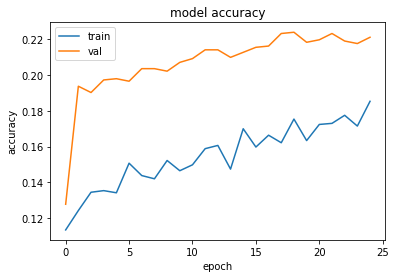

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

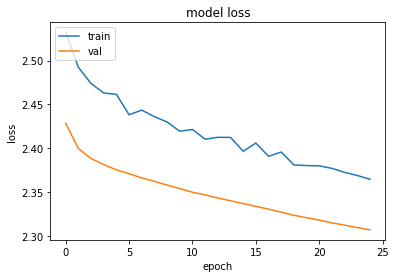

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Resnet 50

In [ ]:
from keras.applications import ResNet152V2
# Instantiate a ResNet50 model with pre-trained weights
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

234545216/234545216 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.5)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.save('Resnet 50_0129.h5')
print(os.path.getsize("Resnet 50_0129.h5")/1048576, "MB")

232.0436248779297 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/25
52/52 [==============================] - 194s 4s/step - loss: 2.6421 - accuracy: 0.1408 - val_loss: 2.2143 - val_accuracy: 0.2547
Epoch 2/25
52/52 [==============================] - 183s 4s/step - loss: 2.3554 - accuracy: 0.2205 - val_loss: 2.0180 - val_accuracy: 0.3796
Epoch 3/25
52/52 [==============================] - 184s 4s/step - loss: 2.1366 - accuracy: 0.2956 - val_loss: 1.8729 - val_accuracy: 0.4498
Epoch 4/25
52/52 [==============================] - 186s 4s/step - loss: 2.0185 - accuracy: 0.3323 - val_loss: 1.7577 - val_accuracy: 0.4856
Epoch 5/25
52/52 [==============================] - 174s 3s/step - loss: 1.8956 - accuracy: 0.3844 - val_loss: 1.6636 - val_accuracy: 0.5235
Epoch 6/25
52/52 [==============================] - 174s 3s/step - loss: 1.7978 - accuracy: 0.4105 - val_loss: 1.5885 - val_accuracy: 0.5439
Epoch 7/25
52/52 [==============================] - 180s 3s/step - loss: 1.7189 - accuracy: 0.4451 - val_loss: 1.5237 - val_accuracy: 0.5551
Epoch 8/25
52

In [ ]:
model.save('Resnet 50_0129.h5')
print(os.path.getsize("Resnet 50_0129.h5")/1048576, "MB")

232.04591369628906 MB


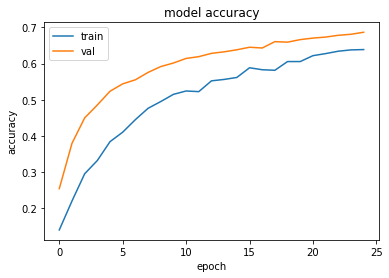

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


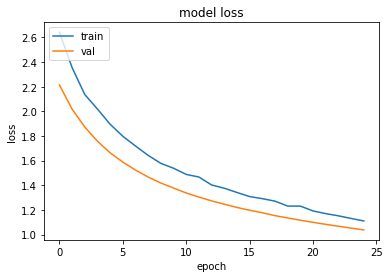

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## INCEPTION V3

In [ ]:
from keras.applications import InceptionV3
# Instantiate a InceptionV3 model with pre-trained weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.5)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.save('INCEPTION_other_0129.h5')


print(os.path.getsize("INCEPTION_other_0129.h5")/1048576, "MB")


92.0603256225586 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/25
52/52 [==============================] - 41s 696ms/step - loss: 2.6457 - accuracy: 0.1323 - val_loss: 2.2719 - val_accuracy: 0.2512
Epoch 2/25
52/52 [==============================] - 34s 655ms/step - loss: 2.4213 - accuracy: 0.1976 - val_loss: 2.1075 - val_accuracy: 0.3235
Epoch 3/25
52/52 [==============================] - 34s 658ms/step - loss: 2.2269 - accuracy: 0.2553 - val_loss: 1.9765 - val_accuracy: 0.4098
Epoch 4/25
52/52 [==============================] - 34s 655ms/step - loss: 2.1113 - accuracy: 0.3035 - val_loss: 1.8700 - val_accuracy: 0.4561
Epoch 5/25
52/52 [==============================] - 34s 654ms/step - loss: 2.0082 - accuracy: 0.3386 - val_loss: 1.7831 - val_accuracy: 0.4856
Epoch 6/25
52/52 [==============================] - 34s 654ms/step - loss: 1.9254 - accuracy: 0.3609 - val_loss: 1.7070 - val_accuracy: 0.5088
Epoch 7/25
52/52 [==============================] - 34s 655ms/step - loss: 1.8334 - accuracy: 0.4090 - val_loss: 1.6429 - val_accuracy: 0.5319

In [ ]:
model.save('INCEPTION_other_0129.h5')


print(os.path.getsize("INCEPTION_other_0129.h5")/1048576, "MB")



92.06269073486328 MB


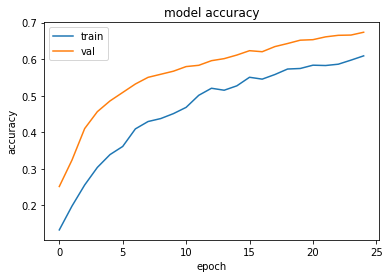

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


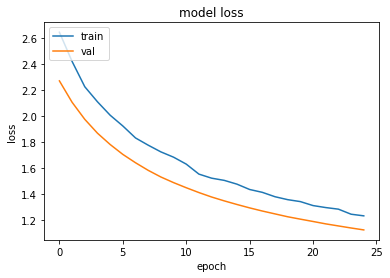

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



## XCEPTION

In [ ]:
from keras.applications import Xception
# Instantiate a Xception model with pre-trained weights
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.5)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.save('XCEPTION_other_0129.h5')


print(os.path.getsize("XCEPTION_other_0129.h5")/1048576, "MB")


88.02407836914062 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/25
52/52 [==============================] - 85s 2s/step - loss: 2.5501 - accuracy: 0.0791 - val_loss: 2.4888 - val_accuracy: 0.0968
Epoch 2/25
52/52 [==============================] - 83s 2s/step - loss: 2.4990 - accuracy: 0.0953 - val_loss: 2.4276 - val_accuracy: 0.1825
Epoch 3/25
52/52 [==============================] - 85s 2s/step - loss: 2.4207 - accuracy: 0.1489 - val_loss: 2.3771 - val_accuracy: 0.2316
Epoch 4/25
52/52 [==============================] - 85s 2s/step - loss: 2.3824 - accuracy: 0.1841 - val_loss: 2.3329 - val_accuracy: 0.2561
Epoch 5/25
52/52 [==============================] - 85s 2s/step - loss: 2.3455 - accuracy: 0.2090 - val_loss: 2.2928 - val_accuracy: 0.2744
Epoch 6/25
52/52 [==============================] - 85s 2s/step - loss: 2.2978 - accuracy: 0.2343 - val_loss: 2.2562 - val_accuracy: 0.3004
Epoch 7/25
52/52 [==============================] - 86s 2s/step - loss: 2.2583 - accuracy: 0.2550 - val_loss: 2.2225 - val_accuracy: 0.3172
Epoch 8/25
52/52 [==

In [ ]:
model.save('XCEPTION_other_0129.h5')


print(os.path.getsize("XCEPTION_other_0129.h5")/1048576, "MB")



88.02644348144531 MB


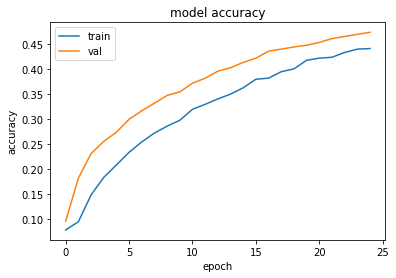

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


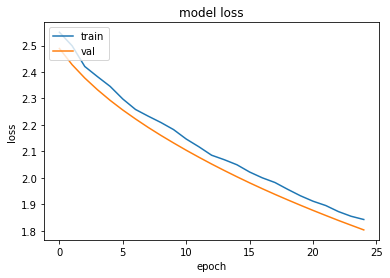

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



## **DenseNet121**

In [ ]:
from keras.applications import DenseNet121
# Instantiate a DenseNet121 model with pre-trained weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_5[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.5)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_5[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.save('DenseNet121_other_0129.h5')


print(os.path.getsize("DenseNet121_other_0129.h5")/1048576, "MB")


32.025970458984375 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/25
52/52 [==============================] - 95s 2s/step - loss: 2.6270 - accuracy: 0.1071 - val_loss: 2.3512 - val_accuracy: 0.1895
Epoch 2/25
52/52 [==============================] - 85s 2s/step - loss: 2.4614 - accuracy: 0.1516 - val_loss: 2.2276 - val_accuracy: 0.2947
Epoch 3/25
52/52 [==============================] - 85s 2s/step - loss: 2.3526 - accuracy: 0.1910 - val_loss: 2.1304 - val_accuracy: 0.3453
Epoch 4/25
52/52 [==============================] - 85s 2s/step - loss: 2.2332 - accuracy: 0.2403 - val_loss: 2.0486 - val_accuracy: 0.3670
Epoch 5/25
52/52 [==============================] - 85s 2s/step - loss: 2.1570 - accuracy: 0.2728 - val_loss: 1.9768 - val_accuracy: 0.3979
Epoch 6/25
52/52 [==============================] - 86s 2s/step - loss: 2.0930 - accuracy: 0.3044 - val_loss: 1.9128 - val_accuracy: 0.4309
Epoch 7/25
52/52 [==============================] - 86s 2s/step - loss: 2.0179 - accuracy: 0.3377 - val_loss: 1.8569 - val_accuracy: 0.4575
Epoch 8/25
52/52 [==

In [ ]:
model.save('DenseNet121_other_0129.h5')


print(os.path.getsize("DenseNet121_other_0129.h5")/1048576, "MB")



32.02825164794922 MB


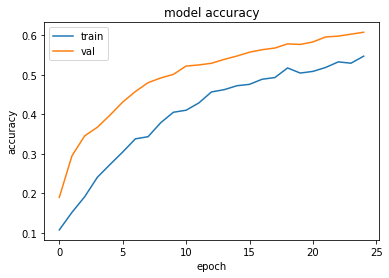

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


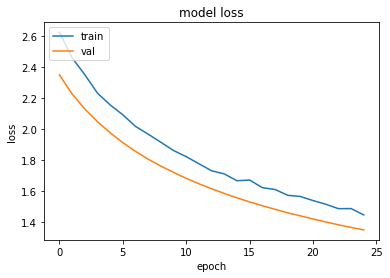

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



### MobileNetV2

In [ ]:
from keras.applications import MobileNetV2
# Instantiate a DenseNet121 model with pre-trained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.5)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.save('MobileNetV2_0129.h5')


print(os.path.getsize("MobileNetV2_0129.h5")/1048576, "MB")


14.125572204589844 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=100, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/100
52/52 [==============================] - 31s 549ms/step - loss: 2.7924 - accuracy: 0.1137 - val_loss: 2.2068 - val_accuracy: 0.2737
Epoch 2/100
52/52 [==============================] - 27s 520ms/step - loss: 2.4149 - accuracy: 0.2093 - val_loss: 1.9961 - val_accuracy: 0.3832
Epoch 3/100
52/52 [==============================] - 28s 547ms/step - loss: 2.2413 - accuracy: 0.2605 - val_loss: 1.8414 - val_accuracy: 0.4421
Epoch 4/100
52/52 [==============================] - 27s 527ms/step - loss: 2.0790 - accuracy: 0.3026 - val_loss: 1.7271 - val_accuracy: 0.4786
Epoch 5/100
52/52 [==============================] - 26s 509ms/step - loss: 1.9547 - accuracy: 0.3669 - val_loss: 1.6359 - val_accuracy: 0.5102
Epoch 6/100
52/52 [==============================] - 27s 513ms/step - loss: 1.8595 - accuracy: 0.3922 - val_loss: 1.5601 - val_accuracy: 0.5389
Epoch 7/100
52/52 [==============================] - 26s 500ms/step - loss: 1.7747 - accuracy: 0.4235 - val_loss: 1.4986 - val_accuracy:

In [ ]:
model.save('DenseNet121_other_0129.h5')


print(os.path.getsize("DenseNet121_other_0129.h5")/1048576, "MB")



14.127937316894531 MB


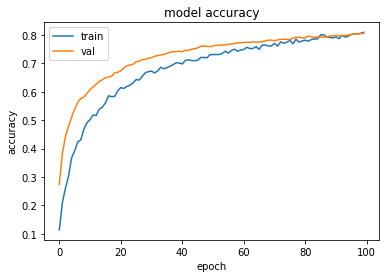

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


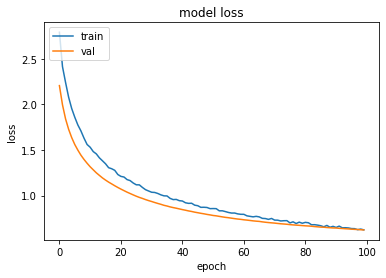

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



## **Predict train model**

In [ ]:
predictions = model.predict(X_test)

45/45 [==============================] - 8s 161ms/step


In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = np.argmax(true_label[i]), img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% \n({})".format(np.array(df.Name)[predicted_label],
                                100*np.max(predictions_array),
                                np.array(df.Name)[true_label]),
                                color=color)

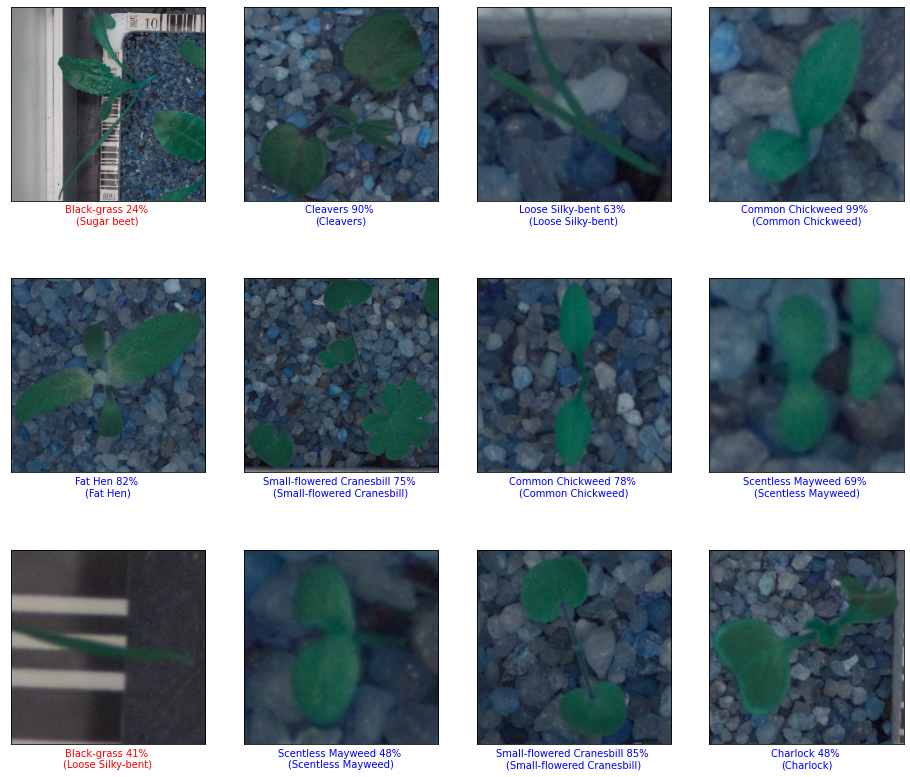

In [ ]:
fig=plt.figure(figsize=(16, 20))
rows, cols = 3,4
for i in range(0, cols*rows):
    fig.add_subplot(rows, cols, i+1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplots_adjust(hspace=-0.5)
plt.show()